In [1]:
## Imports

## Main Code
# We will use the feature_handler class to extract features from the point clouds
from blobBgone.featureHandler import featureHandler
from blobBgone.utils import pyDialogue as pD
## MISC
import os
import glob
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans

### In this Notebook, we will take a look at the performance for Blob-B-Gone when applied to a variety of MINFLUX SPT data taken on GUVs.
In order to thouroughly test the the ability to select and remove blobs from freely diffusing particles, we have chosen blob data with significant variance in appearance and symmetry.

In [2]:
## We will have a seriously unbalanced dataset due to the nature of the data collection
# Blobs are rather on the rare side (luckily) but will nevertheless appear in ANY SPT dataset
# Due to this, we have a significantly higher number of non-blob points than blob points.

## With the following flag, you can turn on/off the equalization of the class counts.
# Such, we guarantee intuitive comparison of feature distributions and performance metrics.
# As we DO care about labels here, we will randomly sample the datasets, keeping tracks of all IDs.

equalize_classes = True

number = 11

In [3]:
## Grab blob and track files
# We will use the grab_specific_files function to grab the blob and track files
# This method returns a list of all the files in the current directory that end with .npy

# If you are on Windows, you can leave the path argument as None to automatically call the explorer

def grab_specific_files(path:str = None, key:str = '3D_P'):
    if path == None:
        try:
            path = pD.askDIR()
        except:
            path = input("Please enter the path to the point clouds: ")
            
    assert os.path.exists(path), "Path does not exist"
    assert os.path.isdir(path), "Path must be a directory"
    
    return np.array(glob.glob(os.path.join(path, f"{key}*.npy")))

blob_paths = grab_specific_files(path = "Example_Data/Additional_MFX_Data/Labelled_Data/blob/", key = 'blob')
track_paths = grab_specific_files(path = "Example_Data/Additional_MFX_Data/Labelled_Data/free/", key = 'free')

print(f"Found {len(blob_paths)} blob files in the '{blob_paths[0].split(os.sep)[-2]}' directory.")
print(f"Found {len(track_paths)} track files in the '{track_paths[0].split(os.sep)[-2]}' directory.")

Found 107 blob files in the 'Example_Data/Additional_MFX_Data/Labelled_Data/blob' directory.
Found 517 track files in the 'Example_Data/Additional_MFX_Data/Labelled_Data/free' directory.


In [4]:
# In this example, the IDs are used to identify if the track is a blob or not
# Reference:
#   - ID in [0,142] -> freely diffusing marker
#   - ID in [143,659] -> blob (artifactual marker)

# Let's assign these files to ground truth IDs
blob_ID = np.array(list(range(1, len(blob_paths) + 1)))
free_ID = np.array(list(range(len(blob_ID) + 1, len(track_paths) + len(blob_ID) + 1)))

print(f"Blobs: {min(blob_ID)} - {max(blob_ID)}")
print(f"Tracks: {min(free_ID)} - {max(free_ID)}")

Blobs: 1 - 107
Tracks: 108 - 624


In [5]:
## Equalize the class count (optional)
# We will use the numpy random generator to randomly sample the datasets

if equalize_classes:
    print("Class count equalization is turned on.")
    gen = np.random.Generator(np.random.PCG64(42)) # This is the same seed as used in the Feature_Exploration notebook to ensure consistency between those two.
    
    min_length = min(len(blob_paths), len(track_paths))
    blob_selection = gen.choice(len(blob_paths), size=min_length, replace=False).astype(int)
    track_selection = gen.choice(len(track_paths), size=min_length, replace=False).astype(int)
    
    blob_paths = blob_paths[blob_selection]
    track_paths = track_paths[track_selection]
    
    blob_ID = blob_ID[blob_selection]
    free_ID = free_ID[track_selection]
    
    print(f"New blob count: {len(blob_paths)}")
    print(f"New track count: {len(track_paths)}")
    
    print(f"New blob IDs: {min(blob_ID)} - {max(blob_ID)}")
    print(f"New track IDs: {min(free_ID)} - {max(free_ID)}")
    
else:
    print("Class count equalization is turned off.")

Class count equalization is turned on.
New blob count: 107
New track count: 107
New blob IDs: 1 - 107
New track IDs: 112 - 621


Feature Handler (ID = 94, dimension = 2, length = 771)

Features in place.
 - None
 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()

 -------------------------------------------------------- 

The Id of the track chosen belongs to the blob category.
Let's check the track to verify this:


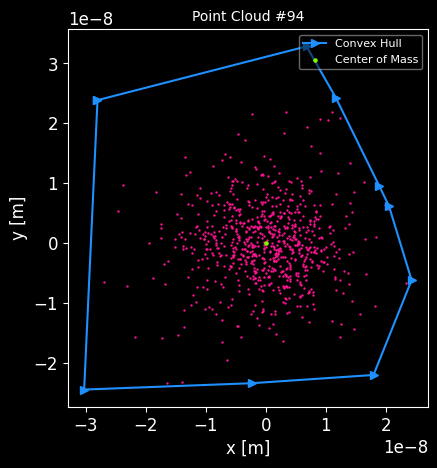

Looks like a blob to me!


In [6]:
## Setup the task list
# We will use the task list to keep track of the files that have been processed
# Each feature handler is designed to handle one point cloud at a time for flexibility

blob_list = [featureHandler.from_npy(path = file, verbose = False) for file in blob_paths]
track_list = [featureHandler.from_npy(path = file, verbose = False) for file in track_paths]


for i, track in enumerate(track_list):
    track.ID = free_ID[i]

task_list = blob_list + track_list

# Get a quick look at the first file
print(task_list[number])



print("\n -------------------------------------------------------- \n")
print(f"The Id of the track chosen belongs to the {'blob' if task_list[number].ID in blob_ID else 'freely diffusing marker'} category.")
print("Let's check the track to verify this:")

task_list[number].overview()

print(f"Looks like a {'blob' if task_list[number].ID in blob_ID else 'freely diffusing marker'} to me!")

In [7]:
## Blob-B-Gone
# We will use a slightly modified version of the Blob-B-Gone algorithm to cluster the features
# modifications made are as follows:
#   - The algorithm doe not load the data from the files, but rather uses a task list as input which can be optionally equalized
#   - The algorithm opens up the possibility to apply custom weights to the features, for the use to experiment with
#   - The clustering is seeded with 42 for reproducibility, same as the original example
#   - The algorithm does merely returns the cluster assignments


# Set the parameters
verbose =                   True
regularization_method =     'standardize'
apply_custom_weights =      False
weights =                   np.array([1,1,1,1,1])

def modified_BlobBGone(task_list, verbose, regularization_method, apply_custom_weights, weights):
    if verbose:
        print("\nExtracting features...")
    # Extract features
    features = []
    for task in task_list:
        task.extract()
        features.append(task.to_array())

    # Regularize the features
    features = featureHandler.regularize_output(features, method = regularization_method)
    assert np.all(np.isfinite(features)), "NaN values still present in features."


    if verbose:
        print("\nClustering...")
    # Cluster the features
    clustering_FH  = KMeans(
        n_clusters = 2,
        init = 'k-means++',
        n_init = 'auto',
        max_iter = 300,
        verbose = 0,
        random_state = 42, ## Here, we set the random state to 42 for reproducibility
        )

    if apply_custom_weights:
        fit_predict_FH = clustering_FH.fit_predict([feature_vector * weights for feature_vector in features])

    else:
        fit_predict_FH = clustering_FH.fit_predict(features)

    cluster_1 = [task_list[i] for i in range(len(task_list)) if fit_predict_FH[i] == 0]
    cluster_2 = [task_list[i] for i in range(len(task_list)) if fit_predict_FH[i] == 1]
    comb = [cluster_1, cluster_2]

    ## Evaluate Blobbness ##
    # this is an experimental metric that attempts to decide what cluster is the blob cluster
    if verbose:
        print("\nBlob-score is being calculated...\n")
    c1_blobbness = np.mean([task.features.SPHE/task.features.MAX_DIST for task in cluster_1])
    c2_blobbness = np.mean([task.features.SPHE/task.features.MAX_DIST for task in cluster_2])
    if verbose:
        print("Cluster 1 Blob-score: {:.2f}".format(c1_blobbness))
        print("Cluster 2 Blob-score: {:.2f}".format(c2_blobbness))
        print("Blob-score ratio: 1 : {:.2f}".format(max([c1_blobbness, c2_blobbness])/min([c1_blobbness, c2_blobbness])))
        print(
            "Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(features, fit_predict_FH, metric="euclidean")
        )
        
        print("\nCluster {} has been estimated to be the blob cluster.".format(np.argmax([c1_blobbness, c2_blobbness])+1))

    blobs = [task for task in comb[np.argmax([c1_blobbness, c2_blobbness])]]
    free =  [task for task in comb[np.argmin([c1_blobbness, c2_blobbness])]]
    
    return blobs, free, features

blobs, free, features = modified_BlobBGone(task_list, verbose, regularization_method, apply_custom_weights, weights)


Extracting features...



Clustering...

Blob-score is being calculated...

Cluster 1 Blob-score: 139763615.50
Cluster 2 Blob-score: 4136693.83
Blob-score ratio: 1 : 33.79
Silhouette Coefficient: 0.587

Cluster 1 has been estimated to be the blob cluster.


In [8]:
## Let's create a dictionary to evaluate the performance of the algorithm
# We collect the labels from both IDs and predictions

eval_dict = {}
for task in task_list:
    
    if task in blobs:
        pred = 0
    elif task in free:
        pred = 1
    
    if task.ID in blob_ID:
        true = 0
    elif task.ID in free_ID:
        true = 1
    
    eval_dict[task.ID] = [true, pred]
    
labels_true = np.array([eval_dict[task.ID][0] for task in task_list])
labels_pred = np.array([eval_dict[task.ID][1] for task in task_list])
    
print(f"Our favorite point cloud has been assigned to the {['blob', 'freely diffusing marker'][eval_dict[number][1]]} cluster.")
print(f"Our favorite point cloud is actually a {['blob', 'freely diffusing marker'][eval_dict[number][0]]}.")

Our favorite point cloud has been assigned to the blob cluster.
Our favorite point cloud is actually a blob.


------------------------------

Blobs: 106 tasks
Free: 108 tasks

Blobs
Low_end_ID: 1
High_end_ID: 107

Tracks
Low_end_ID: 12
High_end_ID: 621

------------------------------

Blob Mismatch:[]

Track Mismatches:[12]

Total number of mismatches: 1

------------------------------

Accuracy: 0.9953271028037384
F1 Score: 0.9953270007642756
Homogeneity: 0.962
Completeness: 0.962
V-measure: 0.962
Adjusted Rand Index: 0.981
Adjusted Mutual Information: 0.962
Silhouette Coefficient: 0.587

------------------------------



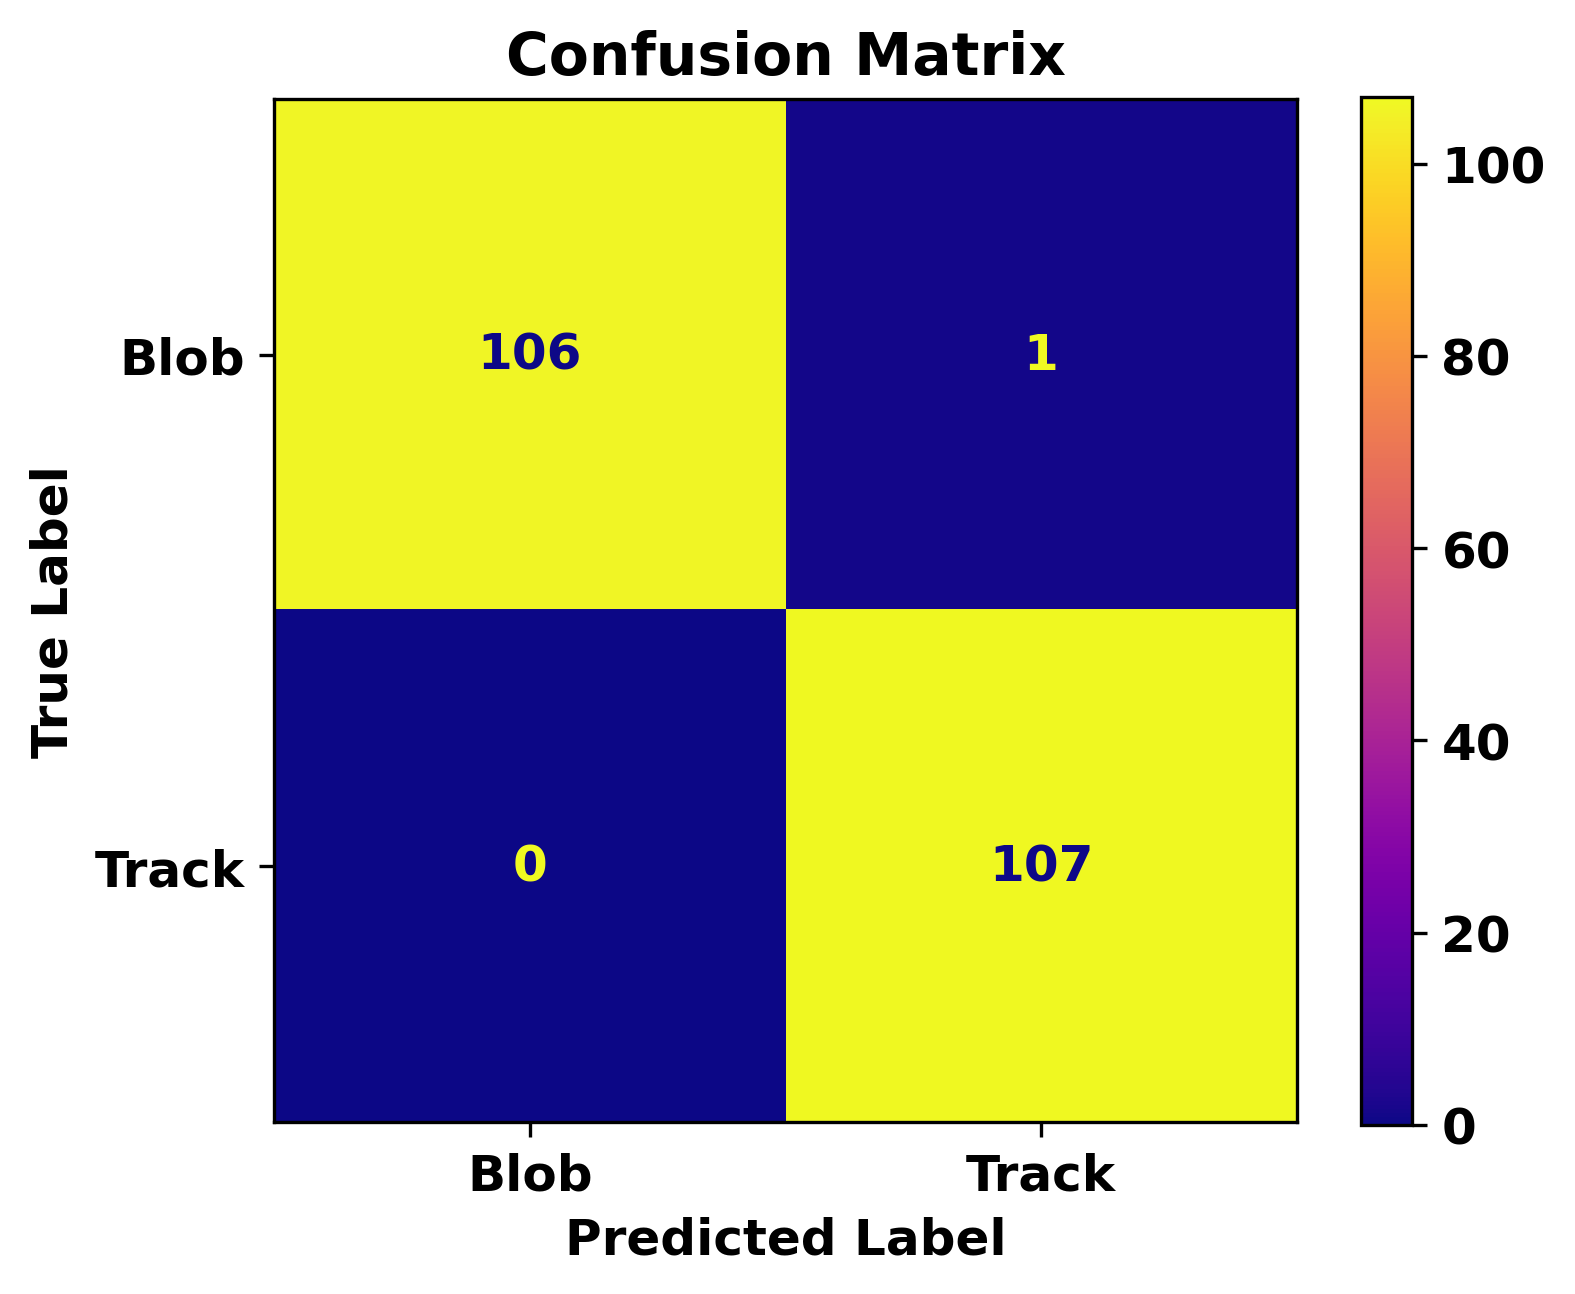

In [9]:
from sklearn import metrics

print("------------------------------\n")

print('Blobs: {} tasks'.format(len(blobs)))
print('Free: {} tasks'.format(len(free)))

print(f"\nBlobs\nLow_end_ID: {min([task.ID for task in blobs])}\nHigh_end_ID: {max([task.ID for task in blobs])}")
print(f"\nTracks\nLow_end_ID: {min([task.ID for task in free])}\nHigh_end_ID: {max([task.ID for task in free])}")

print("\n------------------------------\n")
print(f"Blob Mismatch:{[task.ID for task in blobs if task.ID not in blob_ID]}")
print(f"\nTrack Mismatches:{[task.ID for task in free if task.ID not in free_ID]}")

print(f"\nTotal number of mismatches: {sum(abs(np.array(labels_true)-np.array(labels_pred)))}")

print("\n------------------------------\n")
print(f"Accuracy: {metrics.accuracy_score(labels_true, labels_pred, normalize=True)}")
print(f"F1 Score: {metrics.f1_score(labels_true, labels_pred, average='macro')}")

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_pred))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels_pred))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_pred))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels_pred))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels_pred)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(features, labels_pred, metric="euclidean")
    )
print("\n------------------------------\n")


import matplotlib.pyplot as plt
plt.style.use('default')
cm = metrics.confusion_matrix(labels_true, labels_pred, normalize=None)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blob', 'Track']).plot(cmap = 'plasma')

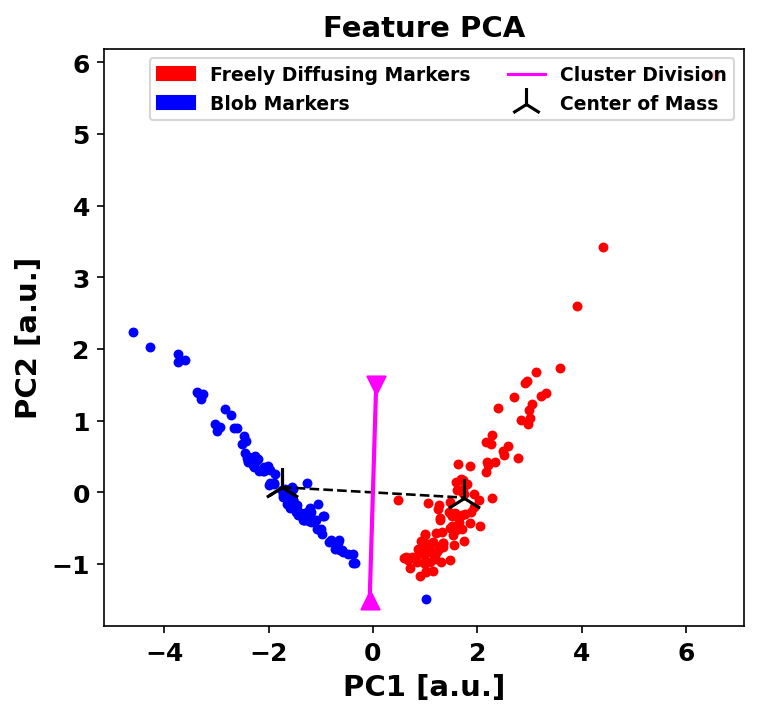

In [10]:
## Feature PCA ##
# To visualize the clustering results, we will use the PCA algorithm to reduce the dimensionality of the features to 2.
# We thus gain the bility to plot the agglomeration of the features in 2D space and highlight the decision boundary.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from blobBgone.utils import Helper

plt.style.use('default')
pca = PCA(n_components=2)
trans= pca.fit_transform(features)

cluster_1_mean = np.array([np.mean(trans[labels_true == 0], axis = 0)[0], np.mean(trans[labels_true == 0], axis = 0)[1]])
cluster_2_mean = np.array([np.mean(trans[labels_true == 1], axis = 0)[0], np.mean(trans[labels_true == 1], axis = 0)[1]])
P1,P2 = Helper.generate_perpendicular_vector(cluster_1_mean, cluster_2_mean, scale = 1.5, direction = 'center')

plt.style.use('default')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(5.5,5), dpi = 150)
ax.scatter(trans[:,0][labels_true == 0], trans[:,1][labels_true == 0], c = 'blue', s = 14)
ax.scatter(trans[:,0][labels_true == 1], trans[:,1][labels_true == 1], c = 'red', s = 14)
ax.scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 350, marker = '2', label = 'Center of Mass')
ax.scatter(cluster_2_mean[0], cluster_2_mean[1], c = 'black', s = 350, marker = '2')
ax.plot([cluster_1_mean[0], cluster_2_mean[0]], [cluster_1_mean[1], cluster_2_mean[1]], '--', c = 'black', linewidth = 1.25)
ax.plot([P1.x, P2.x], [P1.y,P2.y], '-', c = 'magenta', linewidth = 2)
ax.scatter([P1.x], [P1.y], c = 'magenta', s = 75, marker = 'v')
ax.scatter([P2.x], [P2.y], c = 'magenta', s = 75, marker = '^')

ax.set_xlabel('PC1 [a.u.]', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('PC2 [a.u.]', fontsize = 14, fontweight = 'bold')
ax.set_title('Feature PCA', fontsize = 14, fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='Freely Diffusing Markers')
blue_patch = mpatches.Patch(color='blue', label='Blob Markers')
Division = mlines.Line2D([P1.x, P2.x], [P1.y,P2.y],  linestyle = '-',c = 'magenta', label = 'Cluster Division')
CoM =  ax.scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 250, marker = '2', label = 'Center of Mass')


plt.legend(handles=[red_patch, blue_patch, Division, CoM], fontsize = 9, loc = 'upper right', ncol= 2)

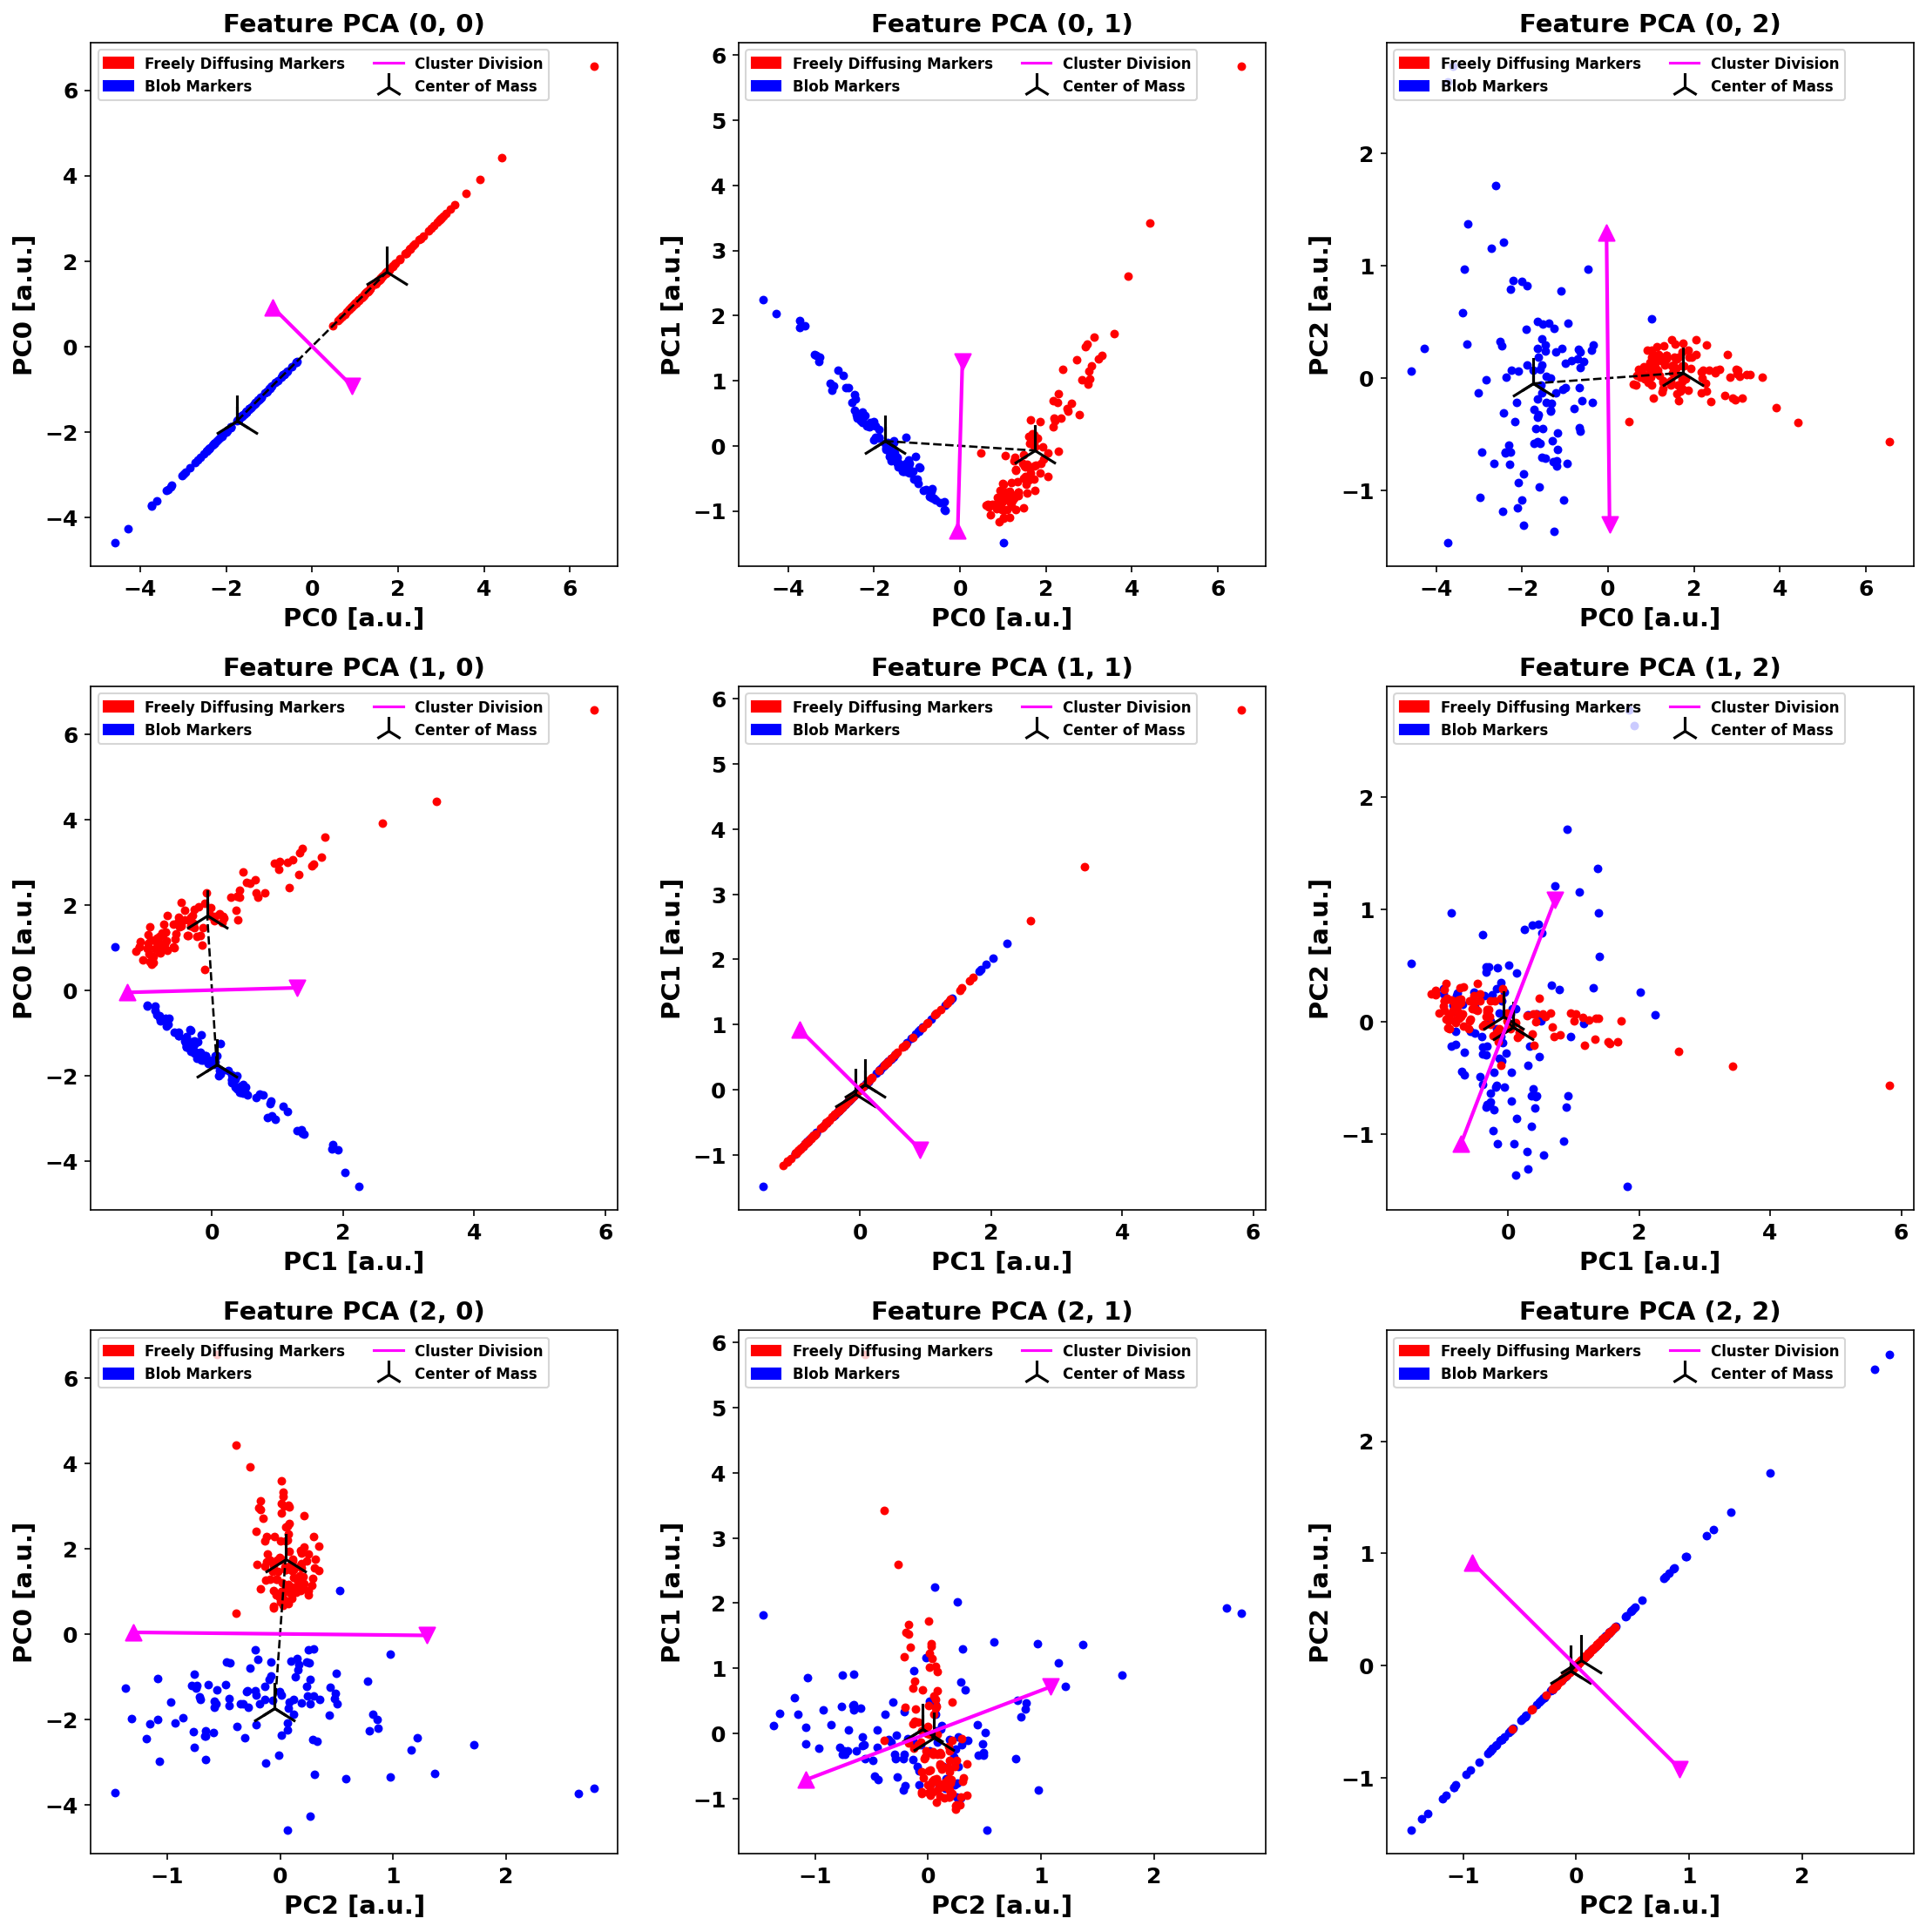

In [11]:
## Feature PCA 3 Components ##
# If we wish to further disect the features, we can use the PCA algorithm to reduce the dimensionality to only 3 components
# We thus gain a bit mroe insight into the features and how they are clustered, however, we have to keep in mind that the original feature space has only 5 dimensions
# Thus, we embrace more variance as compared to the reduction to 2 components.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from blobBgone.utils import Helper

plt.style.use('default')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

n_components = 3

fig, axs = plt.subplots(n_components, n_components, figsize=(18,18), dpi = 150)
plt.subplots_adjust(wspace=0.23, hspace=0.23)

pca = PCA(n_components=n_components)
trans= pca.fit_transform(features)

for i in range(n_components):
    for j in range(n_components):
        cluster_1_mean = np.array([np.mean(trans[labels_true == 0], axis = 0)[i], np.mean(trans[labels_true == 0], axis = 0)[j]])
        cluster_2_mean = np.array([np.mean(trans[labels_true == 1], axis = 0)[i], np.mean(trans[labels_true == 1], axis = 0)[j]])
        P1,P2 = Helper.generate_perpendicular_vector(cluster_1_mean, cluster_2_mean, scale = 1.3, direction = 'center')

        axs[i,j].scatter(trans[:,i][labels_true == 0], trans[:,j][labels_true == 0], c = 'blue', s = 14)
        axs[i,j].scatter(trans[:,i][labels_true == 1], trans[:,j][labels_true == 1], c = 'red', s = 14)
        
        axs[i,j].scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 800, marker = '2', label = 'Center of Mass')
        axs[i,j].scatter(cluster_2_mean[0], cluster_2_mean[1], c = 'black', s = 800, marker = '2')
        
        axs[i,j].plot([cluster_1_mean[0], cluster_2_mean[0]], [cluster_1_mean[1], cluster_2_mean[1]], '--', c = 'black', linewidth = 1.25)
        axs[i,j].plot([P1.x, P2.x], [P1.y,P2.y], '-', c = 'magenta', linewidth = 2)
        axs[i,j].scatter([P1.x], [P1.y], c = 'magenta', s = 75, marker = 'v')
        axs[i,j].scatter([P2.x], [P2.y], c = 'magenta', s = 75, marker = '^')

        axs[i,j].set_xlabel(f'PC{i} [a.u.]', fontsize = 14, fontweight = 'bold')
        axs[i,j].set_ylabel(f'PC{j} [a.u.]', fontsize = 14, fontweight = 'bold')
        axs[i,j].set_title(f'Feature PCA {i,j}', fontsize = 14, fontweight = 'bold')

        red_patch = mpatches.Patch(color='red', label='Freely Diffusing Markers')
        blue_patch = mpatches.Patch(color='blue', label='Blob Markers')
        Division = mlines.Line2D([P1.x, P2.x], [P1.y,P2.y],  linestyle = '-',c = 'magenta', label = 'Cluster Division')
        CoM =  axs[i,j].scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 250, marker = '2', label = 'Center of Mass')


        axs[i,j].legend(handles=[red_patch, blue_patch, Division, CoM], fontsize = 8, loc = 'upper left', ncol= 2)

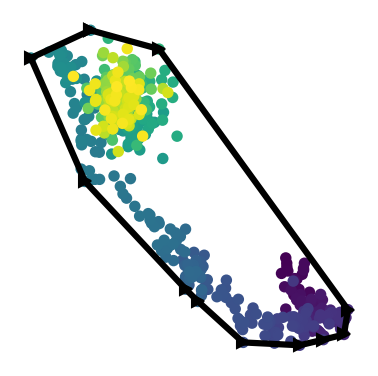

In [12]:
from scipy import spatial
plt.style.use('default')


fig, ax = plt.subplots(figsize=(3,3), dpi = 150)


mis_track = [task for task in free if task.ID not in free_ID][0]
img = ax.scatter(mis_track.pointCloud[:,0], mis_track.pointCloud[:,1], c = np.arange(len(mis_track.pointCloud[:,1])), s = 20, cmap = 'viridis')
ax.plot(*zip(*np.row_stack([*mis_track.pointCloud[spatial.ConvexHull(mis_track.pointCloud).vertices], mis_track.pointCloud[spatial.ConvexHull(mis_track.pointCloud).vertices][0]])), '->', label = "Convex Hull", c = "black", linewidth = 3)
ax.axis('off')

plt.savefig('./Convex_Hull.png', dpi = 300, bbox_inches='tight', transparent = True)

Suspected Artifactual Marker (Blob)

------------------------------



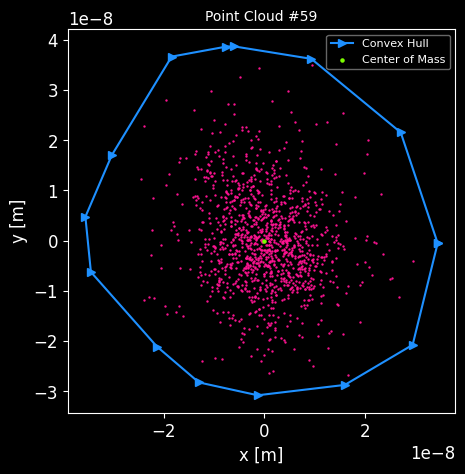

Suspected Free Marker

------------------------------



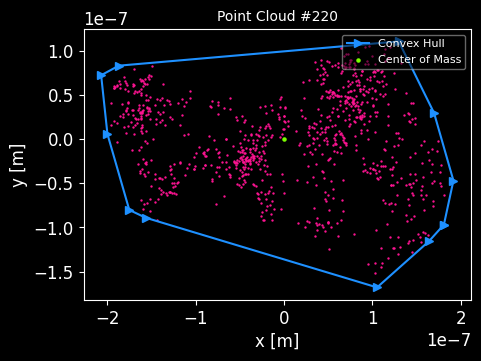

In [13]:
## Seeing is believing ##
import numpy as np
print("Suspected Artifactual Marker (Blob)")
print("\n------------------------------\n")
blobs[np.random.randint(0,len(blobs))].overview()

print("Suspected Free Marker")
print("\n------------------------------\n")
free[np.random.randint(0,len(free))].overview()